In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import json

from src.data.dataset import LocalImageDataset, get_split_indices
from src.model.BasicNet import BasicNet
from src.model.unet import UNet
from src.model.UNetV2 import UNetV2
from src.model.train import train_model, validate_model, save_checkpoint
from src.model.utils import INPUT_DIR, TARGET_DIR, NUM_CHANNELS, NUM_EPOCHS, LEARNING_RATE, BATCH_SIZE, get_device

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
device = get_device()
# model = BasicNet(channels=NUM_CHANNELS)
model = UNetV2(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS, features=[64, 128])
model = model.to(device)
reconstruction_loss = nn.L1Loss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler('cuda')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

num_images = len([f for f in os.listdir(INPUT_DIR) if f.endswith(('.jpg', '.png', '.jpeg', '.webp'))])
num_images = 3

# load test indices
with open("../src/model/test_indices.json", "r") as f:
    test_indices = json.load(f)

train_indices, val_indices = get_split_indices(num_images, test_indices)

train_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, train_indices), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, val_indices), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=BATCH_SIZE, shuffle=True)

best_val_loss = float('inf')
checkpoint_dir = "basic_checkpoints"

In [14]:
NUM_EPOCHS = 1000
BATCH_SIZE = 1
LEARNING_RATE = 0.01

GRAD_CLIP = 1
EDGE_WEIGHT = 0.3

history = {
    "train_loss": [],
    "train_psnr": [],
    "val_loss": [],
    "val_psnr": []
}

In [15]:
for epoch in range(1, NUM_EPOCHS + 1): 
    train_loss, train_psnr = train_model(model, train_loader, optimizer, reconstruction_loss, scaler, GRAD_CLIP, EDGE_WEIGHT, device)
    val_loss, val_psnr = validate_model(model, val_loader, reconstruction_loss, device)
    current_lr = scheduler.get_last_lr()[0]
    print(f"[Epoch {epoch}/{NUM_EPOCHS}]",
            f"Train Loss: {train_loss:.4f}, PSNR: {train_psnr:.2f} | "
            f"Val Loss: {val_loss:.4f}, PSNR: {val_psnr:.2f} | "
            f"lr: {round(current_lr, 5)}")

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     save_checkpoint(epoch+1, model, history, checkpoint_dir)
    
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_psnr"].append(train_psnr)
    history["val_loss"].append(val_loss)
    history["val_psnr"].append(val_psnr)

[Epoch 1/1000] Train Loss: 9.1813, PSNR: 1.10 | Val Loss: 92874.2734, PSNR: -60.64 | lr: 0.01
[Epoch 2/1000] Train Loss: 0.6806, PSNR: 6.76 | Val Loss: 111149.9922, PSNR: -64.38 | lr: 0.01
[Epoch 3/1000] Train Loss: 0.3882, PSNR: 10.84 | Val Loss: 1783.5444, PSNR: -47.11 | lr: 0.01
[Epoch 4/1000] Train Loss: 0.3473, PSNR: 11.06 | Val Loss: 39.1727, PSNR: -28.94 | lr: 0.01
[Epoch 5/1000] Train Loss: 0.2782, PSNR: 14.32 | Val Loss: 3.3641, PSNR: -12.85 | lr: 0.01
[Epoch 6/1000] Train Loss: 0.3154, PSNR: 12.65 | Val Loss: 0.5778, PSNR: 3.22 | lr: 0.01
[Epoch 7/1000] Train Loss: 0.3078, PSNR: 11.82 | Val Loss: 0.1605, PSNR: 15.07 | lr: 0.01
[Epoch 8/1000] Train Loss: 0.2726, PSNR: 14.56 | Val Loss: 0.1342, PSNR: 16.57 | lr: 0.01
[Epoch 9/1000] Train Loss: 0.2524, PSNR: 15.40 | Val Loss: 0.1151, PSNR: 17.07 | lr: 0.01
[Epoch 10/1000] Train Loss: 0.2471, PSNR: 15.07 | Val Loss: 0.1105, PSNR: 17.10 | lr: 0.01
[Epoch 11/1000] Train Loss: 0.2506, PSNR: 14.87 | Val Loss: 0.1306, PSNR: 16.66 | lr

In [16]:
from src.model.BetterNet import BetterNet
device = get_device()
# model = BasicNet(channels=NUM_CHANNELS)
model_2 = BetterNet(input_channels=1, middle_channels=3, num_middle_layers=3)
model_2 = model_2.to(device)
reconstruction_loss = nn.L1Loss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler('cuda')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

num_images = len([f for f in os.listdir(INPUT_DIR) if f.endswith(('.jpg', '.png', '.jpeg', '.webp'))])
num_images = 3

# load test indices
with open("../src/model/test_indices.json", "r") as f:
    test_indices = json.load(f)

train_indices, val_indices = get_split_indices(num_images, test_indices)

train_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, train_indices), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, val_indices), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(LocalImageDataset(INPUT_DIR, TARGET_DIR, test_indices), batch_size=BATCH_SIZE, shuffle=True)

best_val_loss = float('inf')
checkpoint_dir = "basic_checkpoints"


/Users/ericxia/Library/Caches/pypoetry/virtualenvs/text-sharpener-Pto5mSZ8-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [17]:
NUM_EPOCHS = 1000
BATCH_SIZE = 1
LEARNING_RATE = 0.01

GRAD_CLIP = 1
EDGE_WEIGHT = 0.3

history = {
    "train_loss": [],
    "train_psnr": [],
    "val_loss": [],
    "val_psnr": []
}

In [18]:
for epoch in range(1, NUM_EPOCHS + 1): 
    train_loss, train_psnr = train_model(model_2, train_loader, optimizer, reconstruction_loss, scaler, GRAD_CLIP, EDGE_WEIGHT, device)
    val_loss, val_psnr = validate_model(model_2, val_loader, reconstruction_loss, device)
    current_lr = scheduler.get_last_lr()[0]
    print(f"[Epoch {epoch}/{NUM_EPOCHS}]",
            f"Train Loss: {train_loss:.4f}, PSNR: {train_psnr:.2f} | "
            f"Val Loss: {val_loss:.4f}, PSNR: {val_psnr:.2f} | "
            f"lr: {round(current_lr, 5)}")

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     save_checkpoint(epoch+1, model, history, checkpoint_dir)
    
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_psnr"].append(train_psnr)
    history["val_loss"].append(val_loss)
    history["val_psnr"].append(val_psnr)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/text-sharpener-Pto5mSZ8-py3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1, 1, 128, 128])) that is different to the input size (torch.Size([1, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: Given groups=1, weight of size [1, 1, 3, 3], expected input[1, 3, 128, 128] to have 1 channels, but got 3 channels instead

In [29]:
# load image 131, 0
image_idx = 1
image_name = f"Image_{image_idx}.png"
input_image = Image.open(os.path.join(INPUT_DIR, image_name))
target_image = Image.open(os.path.join(TARGET_DIR, image_name))
input_tensor =  torch.tensor(np.array(input_image, dtype=np.float32)).unsqueeze(0) / 255.0
target_tensor = torch.tensor(np.array(target_image, dtype=np.float32)).unsqueeze(0) / 255.0

# make prediction
output_tensor = model(input_tensor.unsqueeze(0))

# post-process prediction backgroun
background_threshold = 0.9
output_tensor = torch.where(output_tensor > background_threshold, torch.tensor(1.0), output_tensor)

text_threshold = 0.5 
output_tensor = torch.where(output_tensor < text_threshold, torch.tensor(0.0), output_tensor)


# process before plot
input_image_numpy = (input_tensor).permute(1, 2, 0).detach().numpy()
target_image_numpy = (target_tensor).permute(1, 2, 0).detach().numpy()
output_image_numpy = (output_tensor[0]).permute(1, 2, 0).detach().numpy()

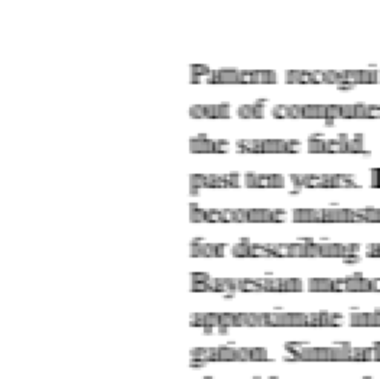

In [30]:
plt.imshow(input_image_numpy, cmap='gray')
plt.axis('off')
plt.show()

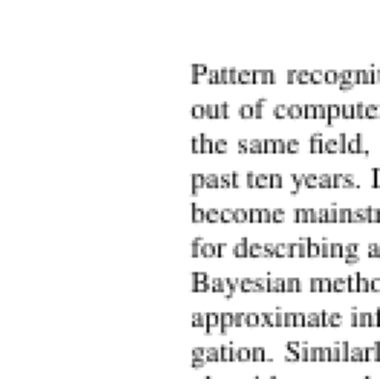

In [31]:
plt.imshow(target_image_numpy, cmap='gray')
plt.axis('off')
plt.show()

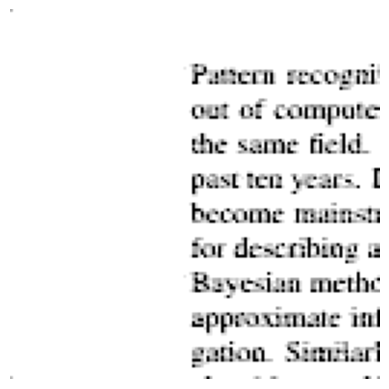

In [32]:
plt.imshow(output_image_numpy, cmap='gray')
plt.axis('off')
plt.show()

In [17]:
target_image_actual

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [18]:
output_image

array([[[0.957484  ],
        [1.0000019 ],
        [1.0002987 ],
        ...,
        [1.0017195 ],
        [1.0092598 ],
        [1.0000896 ]],

       [[0.9970744 ],
        [1.0011039 ],
        [1.0589988 ],
        ...,
        [1.0003548 ],
        [0.9681495 ],
        [0.96380466]],

       [[1.0011365 ],
        [0.99201065],
        [0.9989091 ],
        ...,
        [1.0007217 ],
        [1.0164142 ],
        [1.0162363 ]],

       ...,

       [[0.98120147],
        [0.98162204],
        [1.0152979 ],
        ...,
        [0.998707  ],
        [1.0014615 ],
        [0.9972499 ]],

       [[1.0006323 ],
        [0.9997412 ],
        [1.0001439 ],
        ...,
        [0.9990355 ],
        [0.967625  ],
        [0.99992514]],

       [[1.0000231 ],
        [1.0002475 ],
        [0.99984145],
        ...,
        [1.0150113 ],
        [1.0006101 ],
        [0.87158227]]], dtype=float32)